# Energy Forecasting with SARIMAX

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#Read data and make sure dates are indexed
df=pd.read_csv('EnergyConsumption.csv',index_col='Datetime',parse_dates=True)
df=df.dropna()
print('Shape of data',df.shape)
df.head()

Shape of data (121273, 1)


,AEP_MW
Datetime,
2004-12-31 01:00:00,13478
2004-12-31 02:00:00,12865
2004-12-31 03:00:00,12577
2004-12-31 04:00:00,12517
2004-12-31 05:00:00,12670


In [3]:
#Sum energy consumption by days
df = df.resample('M').sum()
df

,AEP_MW
Datetime,
2004-10-31,10349073
2004-11-30,10677917
2004-12-31,12452864
2005-01-31,12735114
2005-02-28,11085745
...,...
2018-04-30,9820256
2018-05-31,10503052
2018-06-30,11019780


<Axes: xlabel='Datetime', ylabel='AEP_MW'>

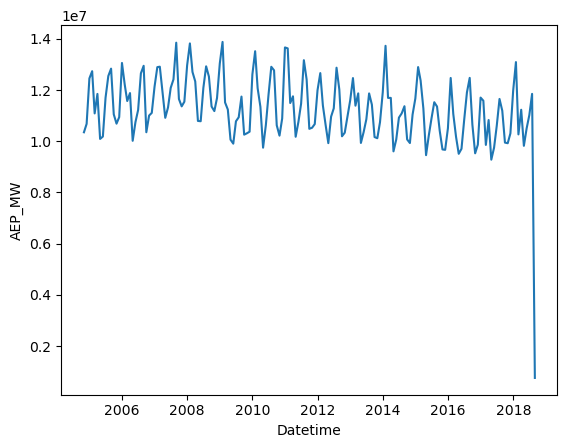

In [4]:
sns.lineplot(data=df,x=df.index, y=df.AEP_MW)

In [5]:
# Remove last day, not representative of data set as hours were grouped and summed
df = df.iloc[:-1]
df.tail()

,AEP_MW
Datetime,
2018-03-31,11228646
2018-04-30,9820256
2018-05-31,10503052
2018-06-30,11019780
2018-07-31,11849407


# Check for Stationarity

Data is Stationary if Mean and variance of dependent variable doesnt vary by the time 

If times series variance doesnt look constant through time, then transform the series to stabilize the variance

I can do this by taking LOG (transform back when making predictions)

# How to Check for Stationarity

Test 1: ADF - Augmented Dickey-Fuller test 
        
        Test Statistics < critical values

Test 2: Rolling Statistics- Rolling mean, rolling std etc.

In [6]:
df['rollMean'] = df.AEP_MW.rolling(window=12).mean()
df['rollStd'] = df.AEP_MW.rolling(window=12).std()

/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/3640678070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollMean'] = df.AEP_MW.rolling(window=12).mean()
/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/3640678070.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollStd'] = df.AEP_MW.rolling(window=12).std()


<Axes: xlabel='Datetime', ylabel='AEP_MW'>

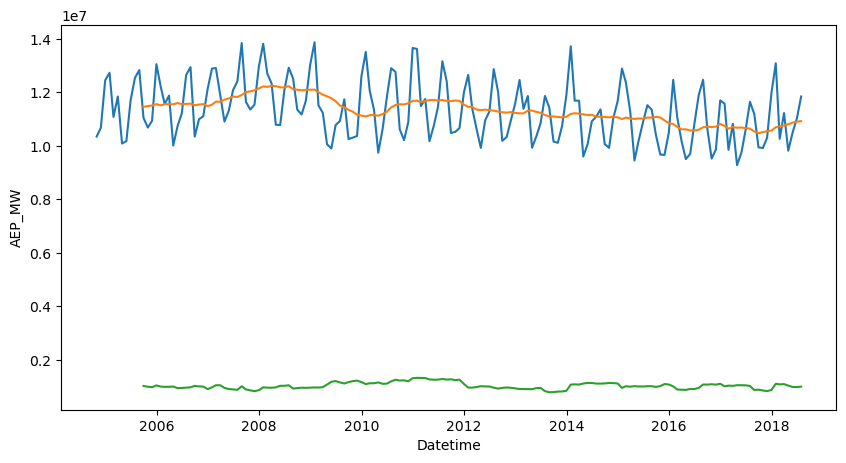

In [7]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df,x=df.index,y=df.AEP_MW)
sns.lineplot(data=df,x=df.index,y=df.rollMean)
sns.lineplot(data=df,x=df.index,y=df.rollStd)

Rolling mean and std is relatively stationary

In [8]:
from statsmodels.tsa.stattools import adfuller

def ad_test(dataset):
    dftest = adfuller(dataset,autolag = 'AIC')
    print("1. Test Statistics : ",dftest[0])
    print("2. P-Value : ",dftest[1])
    print("3. Num of Lags : ",dftest[2])
    print("4. Num of Obeservations Used For ADF Regression and Critical Values Calculation :",dftest[3])
    print("5. Critical Values : ")
    for key, val in dftest[4].items():
        print("/t",key, ": ", val)
ad_test(df['AEP_MW'])  #If the p-value is high it means the dataset is not stationary,i

1. Test Statistics :  -1.763872487192329
2. P-Value :  0.398539692260646
3. Num of Lags :  14
4. Num of Obeservations Used For ADF Regression and Critical Values Calculation : 151
5. Critical Values : 
/t 1% :  -3.4744158894942156
/t 5% :  -2.880878382771059
/t 10% :  -2.577081275821236


The Test Statistic is not less than the critical values this means our data is not stationary

# Making Data Stationary

3 methods to make your data stationary

Method #1 Time Shift - "Differencing"

Method #2 Log

Method #3 Square root,cube...

You can use a combinations like log&sqrt&shift

# Combining all the tests together and making a function to perform the previous tests 

In [9]:
def test_stationary(dataFrame, var):
    dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
    dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()
    
    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(dataFrame[var],autolag = 'AIC')
    stats =pd.Series(adfTest[0:4],index=['Test Statistics','p-value','# Lags used','Num of Obeservations Used'])
    print(stats)
    
    for key,values in adfTest[4].items():
        print('criticality',key,":",values)
    
    sns.lineplot(data=dataFrame,x=dataFrame.index,y=var)
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollMean')
    sns.lineplot(data=dataFrame,x=dataFrame.index,y='rollStd')

Test Statistics               -1.763872
p-value                        0.398540
# Lags used                   14.000000
Num of Obeservations Used    151.000000
dtype: float64
criticality 1% : -3.4744158894942156
criticality 5% : -2.880878382771059
criticality 10% : -2.577081275821236


/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/1638391273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/1638391273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


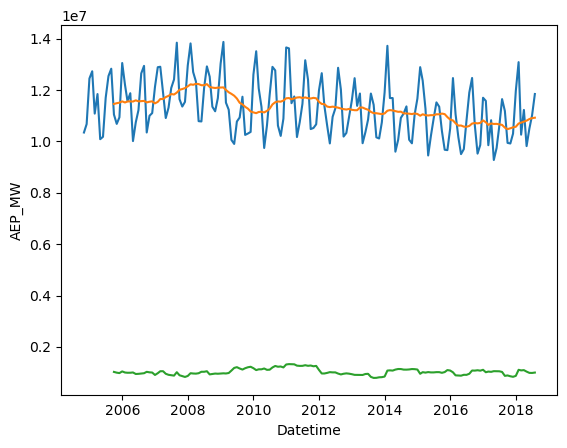

In [10]:
test_stationary(df,'AEP_MW')

In [11]:
air_df = df[['AEP_MW']]
air_df.head()

,AEP_MW
Datetime,
2004-10-31,10349073
2004-11-30,10677917
2004-12-31,12452864
2005-01-31,12735114
2005-02-28,11085745


# Time Shift

In [12]:
# Time Shift

air_df['shift'] = air_df.AEP_MW.shift()
air_df['shiftDiff'] = air_df.AEP_MW - air_df['shift']
air_df.head()

/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/2480590914.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df['shift'] = air_df.AEP_MW.shift()


,AEP_MW,shift,shiftDiff
Datetime,,,
2004-10-31,10349073,NaN,NaN
2004-11-30,10677917,10349073.0,328844.0
2004-12-31,12452864,10677917.0,1774947.0
2005-01-31,12735114,12452864.0,282250.0
2005-02-28,11085745,12735114.0,-1649369.0


Test Statistics               -3.887931
p-value                        0.002125
# Lags used                   13.000000
Num of Obeservations Used    151.000000
dtype: float64
criticality 1% : -3.4744158894942156
criticality 5% : -2.880878382771059
criticality 10% : -2.577081275821236


/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/1638391273.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollMean'] = dataFrame[var].rolling(window=12).mean()
/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/1638391273.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataFrame['rollStd'] = dataFrame[var].rolling(window=12).std()


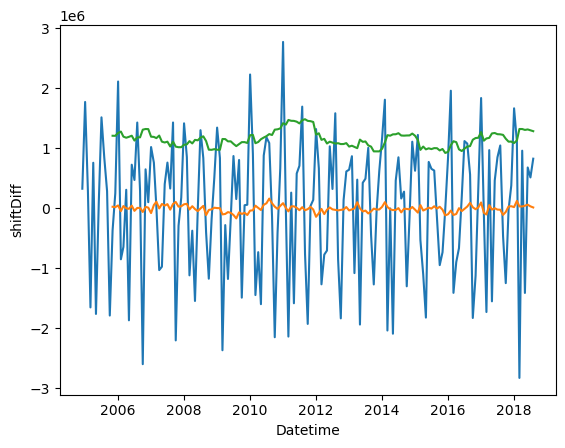

In [13]:
test_stationary(air_df.dropna(),'shiftDiff')

Test statistic is now lower that critical values, dataset is now stationary

Lets try the other methods as well

# Log 

In [14]:
# Log 
log_df = df[['AEP_MW']]
log_df['log'] = np.log(log_df['AEP_MW'])
log_df

#I can test stationarity directly with log variable or i can combine shift with log

/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/1811496830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  log_df['log'] = np.log(log_df['AEP_MW'])


,AEP_MW,log
Datetime,,
2004-10-31,10349073,16.152408
2004-11-30,10677917,16.183688
2004-12-31,12452864,16.337461
2005-01-31,12735114,16.359874
2005-02-28,11085745,16.221171
...,...,...
2018-03-31,11228646,16.233979
2018-04-30,9820256,16.099958
2018-05-31,10503052,16.167176


Test Statistics               -1.762793
p-value                        0.399084
# Lags used                   14.000000
Num of Obeservations Used    151.000000
dtype: float64
criticality 1% : -3.4744158894942156
criticality 5% : -2.880878382771059
criticality 10% : -2.577081275821236


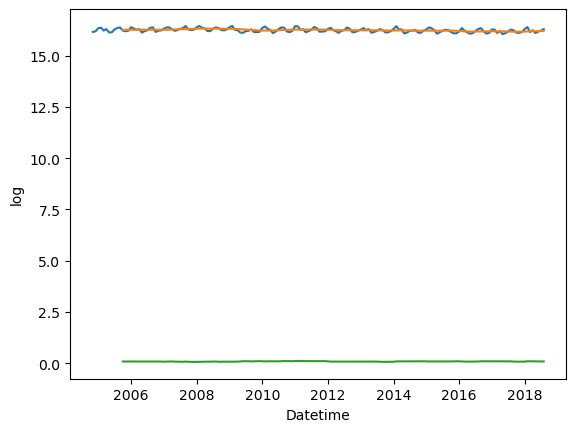

In [15]:
test_stationary(log_df.dropna(),'log')

# SQRT

In [16]:
sqrt_df = df[['AEP_MW']]
sqrt_df['sqrt'] = np.log(sqrt_df['AEP_MW'])
sqrt_df

/var/folders/11/l4fpvyl95h9b678j6bkxz1_h0000gn/T/ipykernel_81152/2682459223.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sqrt_df['sqrt'] = np.log(sqrt_df['AEP_MW'])


,AEP_MW,sqrt
Datetime,,
2004-10-31,10349073,16.152408
2004-11-30,10677917,16.183688
2004-12-31,12452864,16.337461
2005-01-31,12735114,16.359874
2005-02-28,11085745,16.221171
...,...,...
2018-03-31,11228646,16.233979
2018-04-30,9820256,16.099958
2018-05-31,10503052,16.167176


Test Statistics               -1.762793
p-value                        0.399084
# Lags used                   14.000000
Num of Obeservations Used    151.000000
dtype: float64
criticality 1% : -3.4744158894942156
criticality 5% : -2.880878382771059
criticality 10% : -2.577081275821236


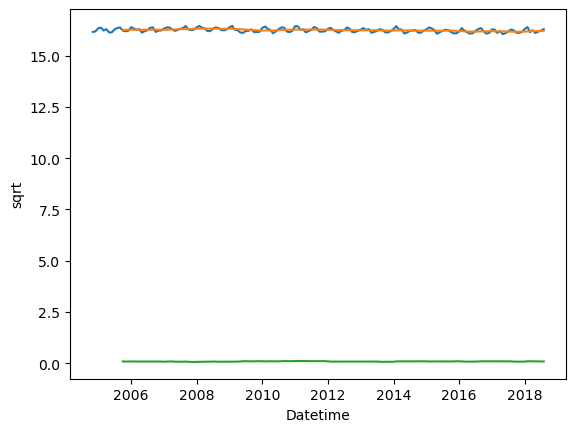

In [17]:
test_stationary(sqrt_df.dropna(),'sqrt')

# Building the model

In [18]:
airp = df[['AEP_MW']].copy(deep=True)
airp['firstdiff'] = airp['AEP_MW'].diff()
airp['diff12'] = airp['AEP_MW'].diff(12)

In [19]:
airp.head()

,AEP_MW,firstdiff,diff12
Datetime,,,
2004-10-31,10349073,NaN,NaN
2004-11-30,10677917,328844.0,NaN
2004-12-31,12452864,1774947.0,NaN
2005-01-31,12735114,282250.0,NaN
2005-02-28,11085745,-1649369.0,NaN


In [20]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

ARIMA 

Integrated = d  By whatever you shifted the model that will go in d

Auto Regressive = p PACF 

Moving average = q ACF

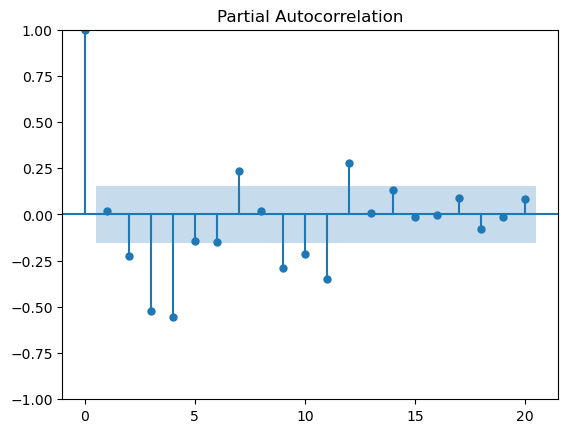

In [21]:
plot_pacf(airp['firstdiff'].dropna(),lags=20);

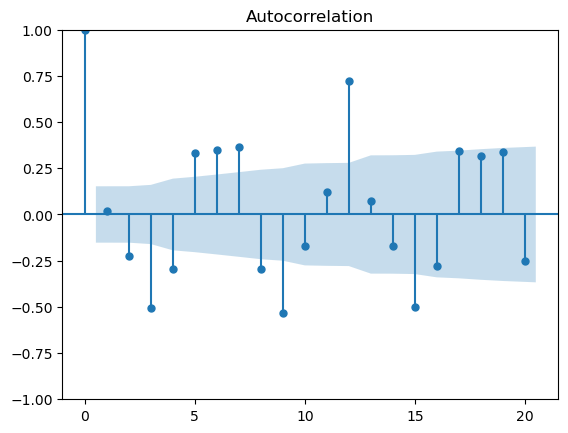

In [22]:
plot_acf(airp['firstdiff'].dropna(),lags=20);

In [23]:
# p = 2 # d = 1 # q = 2 

# ARIMA Model

In [24]:
train = airp[:round(len(airp)*70/100)]
test = airp[round(len(airp)*70/100):]
test.head()

,AEP_MW,firstdiff,diff12
Datetime,,,
2014-06-30,10921235,852498.0,63991.0
2014-07-31,11086809,165574.0,-781107.0
2014-08-31,11367056,280247.0,-61422.0
2014-09-30,10069273,-1297783.0,-92868.0
2014-10-31,9928515,-140758.0,-188042.0


Note: to train the model we are not taking the diff data, that is just used to find the value of p,d,q

In [25]:
model = ARIMA(train['AEP_MW'],order=(2,1,2))
model_fit = model.fit()
pred = model_fit.predict(start=test.index[0],end=test.index[-1])
airp['arimapred'] = pred
airp.tail()

,AEP_MW,firstdiff,diff12,arimapred
Datetime,,,,
2018-03-31,11228646,962728.0,401002.0,1.100480e+07
2018-04-30,9820256,-1408390.0,540660.0,1.016792e+07
2018-05-31,10503052,682796.0,755971.0,9.916440e+06
2018-06-30,11019780,516728.0,419630.0,1.049508e+07
2018-07-31,11849407,829627.0,199779.0,1.133419e+07


<Axes: xlabel='Datetime', ylabel='AEP_MW'>

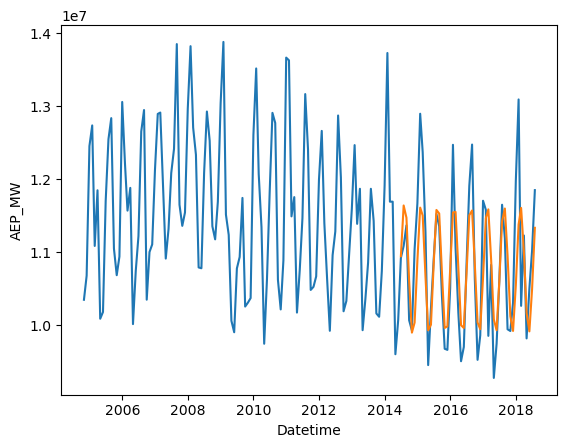

In [26]:
airp.dropna()
sns.lineplot(data=airp,x=airp.index,y='AEP_MW')
sns.lineplot(data=airp,x=airp.index,y='arimapred')

In [27]:
from sklearn.metrics import mean_squared_error

In [28]:
np.sqrt(mean_squared_error(test['AEP_MW'],pred))

675016.2030196276

# SARIMAX model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

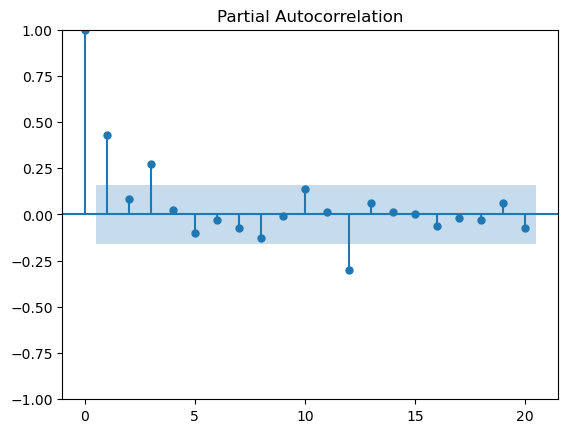

In [30]:
plot_pacf(airp['diff12'].dropna(),lags=20);

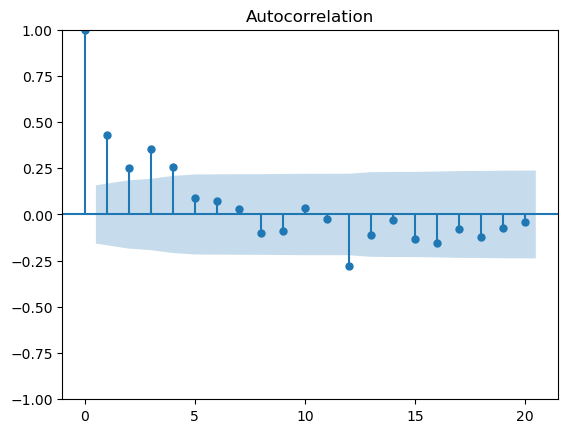

In [31]:
plot_acf(airp['diff12'].dropna(),lags=20);

In [32]:
# p = 1  d = 2  q = 1  s = 12

In [70]:
model = SARIMAX(train['AEP_MW'],order=(1,1,2),seasonal_order=(1,1,2,12))
model_fit = model.fit()
pred = model_fit.predict(start=test.index[0],end=test.index[-1])
airp['sarimaxPred'] = pred

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.44825D+01    |proj g|=  2.00494D+00

At iterate    5    f=  1.31153D+01    |proj g|=  3.21965D-02


 This problem is unconstrained.



At iterate   10    f=  1.31098D+01    |proj g|=  3.64369D-02

At iterate   15    f=  1.31086D+01    |proj g|=  2.30399D-03

At iterate   20    f=  1.31084D+01    |proj g|=  3.78501D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     27      1     0     0   6.911D-05   1.311D+01
  F =   13.108388741040171     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


In [71]:
airp.tail()

,AEP_MW,firstdiff,diff12,arimapred,sarimaxPred
Datetime,,,,,
2018-03-31,11228646,962728.0,401002.0,1.100480e+07,1.119207e+07
2018-04-30,9820256,-1408390.0,540660.0,1.016792e+07,9.449250e+06
2018-05-31,10503052,682796.0,755971.0,9.916440e+06,9.944810e+06
2018-06-30,11019780,516728.0,419630.0,1.049508e+07,1.058848e+07
2018-07-31,11849407,829627.0,199779.0,1.133419e+07,1.164691e+07


Sarimax prediction mode accurate

<Axes: xlabel='Datetime', ylabel='AEP_MW'>

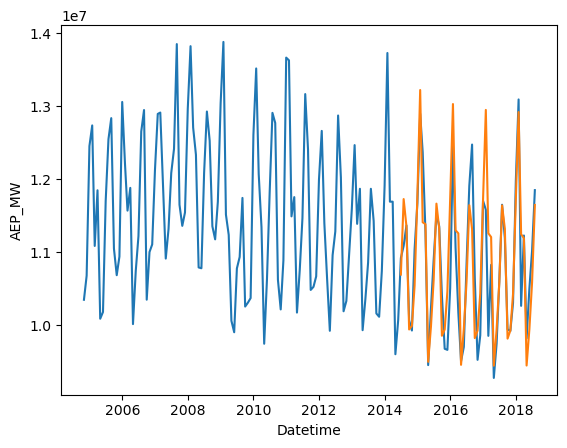

In [72]:
airp.dropna()
sns.lineplot(data=airp,x=airp.index,y='AEP_MW')
sns.lineplot(data=airp,x=airp.index,y='sarimaxPred')

In [73]:
np.sqrt(mean_squared_error(test['AEP_MW'],pred))

539091.9034388452

Error was reduced

In [76]:
futureDate = pd.DataFrame(pd.date_range(start='2018-08-31',end='2019-08-31', freq='MS'),columns=['Dates'])
futureDate.set_index('Dates',inplace=True)
futureDate.head()

""
Dates
2018-09-01
2018-10-01
2018-11-01
2018-12-01
2019-01-01


<Axes: xlabel='Datetime', ylabel='AEP_MW'>

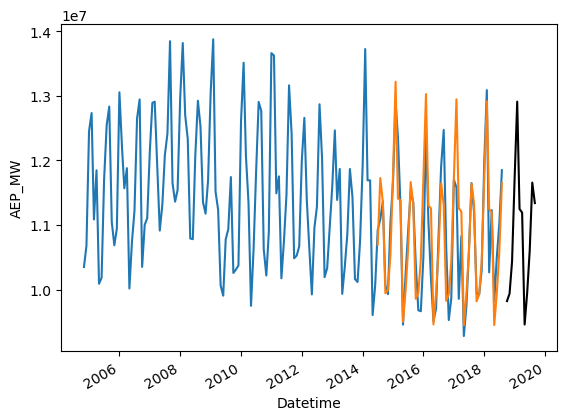

In [80]:
airp.dropna()
sns.lineplot(data=airp,x=airp.index,y='AEP_MW')
sns.lineplot(data=airp,x=airp.index,y='sarimaxPred')
model_fit.predict(start=futureDate.index[0], end=futureDate.index[-1]).plot(color='black')

Next ---->>>> Building a model on transformed data used to make the data stationary 